In [4]:
# importing libraries
import pandas as pd
import numpy as np
import warnings
import math
import datetime
import matplotlib.pyplot as plt

from sklearn import set_config
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler   
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import KernelPCA
import sklearn

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose    

import tensorflow as tf
from tensorflow.keras.models import Model                  
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping      

warnings.filterwarnings("ignore")
np.random.seed(99)
tf.random.set_seed(99)

print("All libraries imported successfully.")


All libraries imported successfully.


In [6]:
# load dataset

import pandas as pd

# Load the mustard dataset
df = pd.read_csv("merged_mustard_reservoir.csv")

print("Dataset loaded successfully.")
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")

# Preview first few rows
print("\nDataset Preview:")
display(df.head())

# Data types of each column
print("\nColumn Data Types:")
display(df.dtypes)

# Check for missing or null values
print("\nMissing / Null Values per Column:")
missing = df.isnull().sum()
if missing.sum() == 0:
    print("No missing values found.")
else:
    display(missing[missing > 0].sort_values(ascending=False))


Dataset loaded successfully.
Shape: 96429 rows × 12 columns

Dataset Preview:


,state_name,crop_name,apy_item_interval_start,temperature_recorded_date,state_temperature_max_val,state_temperature_min_val,state_rainfall_val,yield,FRL,Live Cap FRL,Level,Current Live Storage
0,Andhra Pradesh,rapeseed &mustard,2000,2000-01-01,30.38,14.47,0.0,0.23394,152.296667,2.838333,266.30,6.390
1,Andhra Pradesh,rapeseed &mustard,2000,2000-01-02,30.04,13.96,0.0,0.23394,152.296667,2.838333,266.18,6.330
2,Andhra Pradesh,rapeseed &mustard,2000,2000-01-03,29.92,12.98,0.0,0.23394,152.296667,2.838333,266.09,6.286
3,Andhra Pradesh,rapeseed &mustard,2000,2000-01-04,29.98,12.23,0.0,0.23394,152.296667,2.838333,266.03,6.257
4,Andhra Pradesh,rapeseed &mustard,2000,2000-01-05,29.77,13.24,0.0,0.23394,152.296667,2.838333,265.97,6.228



Column Data Types:


state_name                    object
crop_name                     object
apy_item_interval_start        int64
temperature_recorded_date     object
state_temperature_max_val    float64
state_temperature_min_val    float64
state_rainfall_val           float64
yield                        float64
FRL                          float64
Live Cap FRL                 float64
Level                        float64
Current Live Storage         float64
dtype: object


Missing / Null Values per Column:


Level                   400
Current Live Storage    397
dtype: int64

In [7]:
#verify column names
print("All column names in the dataset:")
for col in df.columns:
    print(f"'{col}'")


All column names in the dataset:
'state_name'
'crop_name'
'apy_item_interval_start'
'temperature_recorded_date'
'state_temperature_max_val'
'state_temperature_min_val'
'state_rainfall_val'
'yield'
'FRL'
'Live Cap FRL'
'Level'
'Current Live Storage'


In [8]:
# Convert date -> Sort -> Drop date -> Check missing values

df = df.copy()

# convert to datetime
df['temperature_recorded_date'] = pd.to_datetime(df['temperature_recorded_date'], errors='coerce')

# sort by date first, then by state
df.sort_values(by=['temperature_recorded_date', 'state_name'], inplace=True)

df.drop(columns=['temperature_recorded_date'], inplace=True)

print(" Sorted by ['temperature_recorded_date', 'state_name'] and dropped 'temperature_recorded_date'.\n")

# Show first rows
print(" Data Preview:")
display(df.head())

# Show missing values BEFORE interpolation
print("\n Missing values BEFORE interpolation:")
print(df.isnull().sum())


 Sorted by ['temperature_recorded_date', 'state_name'] and dropped 'temperature_recorded_date'.

 Data Preview:


,state_name,crop_name,apy_item_interval_start,state_temperature_max_val,state_temperature_min_val,state_rainfall_val,yield,FRL,Live Cap FRL,Level,Current Live Storage
0,Andhra Pradesh,rapeseed &mustard,2000,30.38,14.47,0.0,0.23394,152.296667,2.838333,266.300000,6.390000
8036,Chhattisgarh,rapeseed &mustard,2000,28.95,8.16,0.0,0.33100,377.820000,1.365667,349.965000,1.250500
16437,Gujarat,rapeseed &mustard,2000,31.12,7.11,0.0,1.23526,120.220625,1.030750,111.875714,0.796143
32508,Karnataka,rapeseed &mustard,2000,30.57,12.63,0.0,0.26345,597.731875,1.539062,541.472000,1.578000
36161,Madhya Pradesh,rapeseed &mustard,2000,30.94,6.39,0.0,0.77400,373.365455,2.744818,390.766000,1.312000



 Missing values BEFORE interpolation:
state_name                     0
crop_name                      0
apy_item_interval_start        0
state_temperature_max_val      0
state_temperature_min_val      0
state_rainfall_val             0
yield                          0
FRL                            0
Live Cap FRL                   0
Level                        400
Current Live Storage         397
dtype: int64


In [9]:
# data cleaning after interpolation
for col in df.columns:
    if df[col].dtype != 'object':
        df[col] = df[col].interpolate(method='linear', limit_direction='both')

print(" Linear interpolation done for numeric columns.")
print("\nMissing values per column AFTER interpolation:")
print(df.isnull().sum())


 Linear interpolation done for numeric columns.

Missing values per column AFTER interpolation:
state_name                   0
crop_name                    0
apy_item_interval_start      0
state_temperature_max_val    0
state_temperature_min_val    0
state_rainfall_val           0
yield                        0
FRL                          0
Live Cap FRL                 0
Level                        0
Current Live Storage         0
dtype: int64


In [10]:
#autoencoder-based anomaly removal per state

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

df_auto = df.copy()

num_cols = df_auto.select_dtypes(include=[np.number]).columns.tolist()
if 'yield' in num_cols:
    num_cols.remove('yield')  
    
states = df_auto['state_name'].dropna().unique().tolist()
cleaned_parts = []
total_removed = 0

print("Starting Autoencoder-based anomaly removal process...\n")

for state in states:
    part = df_auto[df_auto['state_name'] == state].copy()

    if len(num_cols) < 1 or part.shape[0] < 50:
        cleaned_parts.append(part)
        print(f"{state}: skipped (insufficient data for Autoencoder training)")
        continue

    scaler = MinMaxScaler()
    X = scaler.fit_transform(part[num_cols])

    input_dim = X.shape[1]
    inp = Input(shape=(input_dim,))
    encoded = Dense(max(2, input_dim // 2), activation='relu')(inp)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    ae = Model(inp, decoded)
    ae.compile(optimizer='adam', loss='mse')

    # Train Autoencoder
    es = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    ae.fit(X, X, epochs=100, batch_size=32, verbose=0, callbacks=[es])

    X_hat = ae.predict(X, verbose=0)
    mse = np.mean((X - X_hat) ** 2, axis=1)

    threshold = mse.mean() + 3 * mse.std()
    keep_mask = mse <= threshold

    removed = int((~keep_mask).sum())
    total_removed += removed

    print(f"{state}: {removed} rows removed out of {part.shape[0]} total rows")

    cleaned_parts.append(part.loc[keep_mask].copy())

df_ae = pd.concat(cleaned_parts, axis=0).sort_index()

print("\nAutoencoder-based anomaly removal completed successfully.")
print(f"Total rows removed across all states: {total_removed}")
display(df_ae.head())


Starting Autoencoder-based anomaly removal process...

Andhra Pradesh: 68 rows removed out of 8036 total rows
Chhattisgarh: 127 rows removed out of 8401 total rows
Gujarat: 91 rows removed out of 8401 total rows
Karnataka: 112 rows removed out of 3653 total rows
Madhya Pradesh: 45 rows removed out of 8036 total rows
Maharashtra: 118 rows removed out of 6210 total rows
Odisha: 17 rows removed out of 1461 total rows
Rajasthan: 92 rows removed out of 8401 total rows
Tamil Nadu: 59 rows removed out of 5844 total rows
Telangana: 62 rows removed out of 5113 total rows
Uttar Pradesh: 204 rows removed out of 8401 total rows
Uttarakhand: 222 rows removed out of 8401 total rows
West Bengal: 89 rows removed out of 8401 total rows
Jharkhand: 75 rows removed out of 7670 total rows

Autoencoder-based anomaly removal completed successfully.
Total rows removed across all states: 1381


,state_name,crop_name,apy_item_interval_start,state_temperature_max_val,state_temperature_min_val,state_rainfall_val,yield,FRL,Live Cap FRL,Level,Current Live Storage
0,Andhra Pradesh,rapeseed &mustard,2000,30.38,14.47,0.0,0.23394,152.296667,2.838333,266.30,6.390
1,Andhra Pradesh,rapeseed &mustard,2000,30.04,13.96,0.0,0.23394,152.296667,2.838333,266.18,6.330
2,Andhra Pradesh,rapeseed &mustard,2000,29.92,12.98,0.0,0.23394,152.296667,2.838333,266.09,6.286
3,Andhra Pradesh,rapeseed &mustard,2000,29.98,12.23,0.0,0.23394,152.296667,2.838333,266.03,6.257
4,Andhra Pradesh,rapeseed &mustard,2000,29.77,13.24,0.0,0.23394,152.296667,2.838333,265.97,6.228


In [20]:
# seasonal decomposition 

from statsmodels.tsa.seasonal import seasonal_decompose

print("Starting seasonal decomposition (additive model)...")

df_season = df_ae.copy()
states = df_season['state_name'].dropna().unique().tolist()

for state in states:
    df_state = df_season[df_season['state_name'] == state].copy()

    if len(df_state) >= 100:
        try:
            series = df_state['yield'].astype(float).interpolate()
            result = seasonal_decompose(series, model='additive', period=100)

            trend = result.trend
            trend_prev = trend.shift(1).bfill()

            df_season.loc[df_state.index, 'yield_trend'] = trend
            df_season.loc[df_state.index, 'yield_trend_prev'] = trend_prev
            df_season.loc[df_state.index, 'yield_detrended'] = series - trend_prev

            print(f"{state}: seasonal decomposition applied.")
        except Exception:
            print(f"{state}: skipped due to insufficient or irregular data.")
    else:
        print(f"{state}: skipped (less than 100 records).")

print("\nSeasonal decomposition completed successfully.")
display(df_season.head())

df = df_season.copy()


Starting seasonal decomposition (additive model)...
Andhra Pradesh: seasonal decomposition applied.
Chhattisgarh: seasonal decomposition applied.
Gujarat: seasonal decomposition applied.
Jharkhand: seasonal decomposition applied.
Karnataka: seasonal decomposition applied.
Madhya Pradesh: seasonal decomposition applied.
Maharashtra: seasonal decomposition applied.
Odisha: seasonal decomposition applied.
Rajasthan: seasonal decomposition applied.
Tamil Nadu: seasonal decomposition applied.
Telangana: seasonal decomposition applied.
Uttarakhand: seasonal decomposition applied.
Uttar Pradesh: seasonal decomposition applied.
West Bengal: seasonal decomposition applied.

Seasonal decomposition completed successfully.


,state_name,crop_name,apy_item_interval_start,state_temperature_max_val,state_temperature_min_val,state_rainfall_val,yield,FRL,Live Cap FRL,Level,Current Live Storage,yield_trend,yield_trend_prev,yield_detrended
0,Andhra Pradesh,rapeseed &mustard,2000,30.38,14.47,0.0,0.23394,152.296667,2.838333,266.30,6.390,NaN,0.23394,2.775558e-17
1,Andhra Pradesh,rapeseed &mustard,2000,30.04,13.96,0.0,0.23394,152.296667,2.838333,266.18,6.330,NaN,0.23394,2.775558e-17
2,Andhra Pradesh,rapeseed &mustard,2000,29.92,12.98,0.0,0.23394,152.296667,2.838333,266.09,6.286,NaN,0.23394,2.775558e-17
3,Andhra Pradesh,rapeseed &mustard,2000,29.98,12.23,0.0,0.23394,152.296667,2.838333,266.03,6.257,NaN,0.23394,2.775558e-17
4,Andhra Pradesh,rapeseed &mustard,2000,29.77,13.24,0.0,0.23394,152.296667,2.838333,265.97,6.228,NaN,0.23394,2.775558e-17


In [21]:
# Global MinMax Scaler (0 to 1)

from sklearn.preprocessing import MinMaxScaler

df_scaled = df_ae.copy()

num_cols_global = df_scaled.select_dtypes(include=[np.number]).columns.tolist()

if num_cols_global:
    scaler_global = MinMaxScaler(feature_range=(0, 1))
    df_scaled[num_cols_global] = scaler_global.fit_transform(df_scaled[num_cols_global])

print(" MinMax scaling done (0–1) on numeric columns.")
display(df_scaled.head())


 MinMax scaling done (0–1) on numeric columns.


,state_name,crop_name,apy_item_interval_start,state_temperature_max_val,state_temperature_min_val,state_rainfall_val,yield,FRL,Live Cap FRL,Level,Current Live Storage
0,Andhra Pradesh,rapeseed &mustard,0.0,0.522647,0.508838,0.0,0.04263,0.105176,0.978309,0.357580,1.000000
1,Andhra Pradesh,rapeseed &mustard,0.0,0.513426,0.491502,0.0,0.04263,0.105176,0.978309,0.357382,0.990610
2,Andhra Pradesh,rapeseed &mustard,0.0,0.510171,0.458192,0.0,0.04263,0.105176,0.978309,0.357232,0.983725
3,Andhra Pradesh,rapeseed &mustard,0.0,0.511798,0.432699,0.0,0.04263,0.105176,0.978309,0.357133,0.979186
4,Andhra Pradesh,rapeseed &mustard,0.0,0.506103,0.467029,0.0,0.04263,0.105176,0.978309,0.357034,0.974648


In [22]:
#ONE-HOT ENCODE 'state_name' 

from sklearn.preprocessing import OneHotEncoder

print("Starting One-Hot Encoding for 'state_name'...")

if 'state_name' in df_scaled.columns:
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    state_ohe = ohe.fit_transform(df_scaled[['state_name']])
    ohe_cols = [f"state_name_{c}" for c in ohe.categories_[0].tolist()]

    df_ohe = pd.DataFrame(state_ohe, columns=ohe_cols, index=df_scaled.index)
    df_final = pd.concat([df_scaled.drop(columns=['state_name']), df_ohe], axis=1)
else:
    df_final = df_scaled.copy()

print("One-Hot Encoding for 'state_name' completed successfully.")
display(df_final.head())


Starting One-Hot Encoding for 'state_name'...
One-Hot Encoding for 'state_name' completed successfully.


,crop_name,apy_item_interval_start,state_temperature_max_val,state_temperature_min_val,state_rainfall_val,yield,FRL,Live Cap FRL,Level,Current Live Storage,...,state_name_Karnataka,state_name_Madhya Pradesh,state_name_Maharashtra,state_name_Odisha,state_name_Rajasthan,state_name_Tamil Nadu,state_name_Telangana,state_name_Uttar Pradesh,state_name_Uttarakhand,state_name_West Bengal
0,rapeseed &mustard,0.0,0.522647,0.508838,0.0,0.04263,0.105176,0.978309,0.357580,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,rapeseed &mustard,0.0,0.513426,0.491502,0.0,0.04263,0.105176,0.978309,0.357382,0.990610,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,rapeseed &mustard,0.0,0.510171,0.458192,0.0,0.04263,0.105176,0.978309,0.357232,0.983725,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,rapeseed &mustard,0.0,0.511798,0.432699,0.0,0.04263,0.105176,0.978309,0.357133,0.979186,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,rapeseed &mustard,0.0,0.506103,0.467029,0.0,0.04263,0.105176,0.978309,0.357034,0.974648,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
#save cleaned dataset locally

output_path = "cleaned_mustard_reservoir_dataset.csv"
df_final.to_csv(output_path, index=False)
print("Cleaning complete.")

print(f"Cleaned dataset saved successfully as '{output_path}'.")
print(f"Final dataset shape: {df_final.shape}")

print("\nRemaining missing values after all steps:")
print(df_final.isnull().sum())


Cleaning complete.
Cleaned dataset saved successfully as 'cleaned_mustard_reservoir_dataset.csv'.
Final dataset shape: (95179, 24)

Remaining missing values after all steps:
crop_name                    0
apy_item_interval_start      0
state_temperature_max_val    0
state_temperature_min_val    0
state_rainfall_val           0
yield                        0
FRL                          0
Live Cap FRL                 0
Level                        0
Current Live Storage         0
state_name_Andhra Pradesh    0
state_name_Chhattisgarh      0
state_name_Gujarat           0
state_name_Jharkhand         0
state_name_Karnataka         0
state_name_Madhya Pradesh    0
state_name_Maharashtra       0
state_name_Odisha            0
state_name_Rajasthan         0
state_name_Tamil Nadu        0
state_name_Telangana         0
state_name_Uttar Pradesh     0
state_name_Uttarakhand       0
state_name_West Bengal       0
dtype: int64


In [86]:
import pandas as pd

df_final = pd.read_csv("cleaned_mustard_reservoir_dataset.csv")
print(" Cleaned dataset loaded.")
print(df_final.shape)
df_final.head()


 Cleaned dataset loaded.
(95179, 24)


,crop_name,apy_item_interval_start,state_temperature_max_val,state_temperature_min_val,state_rainfall_val,yield,FRL,Live Cap FRL,Level,Current Live Storage,...,state_name_Karnataka,state_name_Madhya Pradesh,state_name_Maharashtra,state_name_Odisha,state_name_Rajasthan,state_name_Tamil Nadu,state_name_Telangana,state_name_Uttar Pradesh,state_name_Uttarakhand,state_name_West Bengal
0,rapeseed &mustard,0.0,0.522647,0.508838,0.0,0.04263,0.105176,0.978309,0.357580,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,rapeseed &mustard,0.0,0.513426,0.491502,0.0,0.04263,0.105176,0.978309,0.357382,0.990610,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,rapeseed &mustard,0.0,0.510171,0.458192,0.0,0.04263,0.105176,0.978309,0.357232,0.983725,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,rapeseed &mustard,0.0,0.511798,0.432699,0.0,0.04263,0.105176,0.978309,0.357133,0.979186,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,rapeseed &mustard,0.0,0.506103,0.467029,0.0,0.04263,0.105176,0.978309,0.357034,0.974648,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [87]:
# Restore state_name column from original dataset using index matching

df_original = pd.read_csv("merged_mustard_reservoir.csv") 

# add state_name from original raw file
df['state_name'] = df_original['state_name']

print(" Restored 'state_name'. Unique states:", df['state_name'].nunique())
df.head()


 Restored 'state_name'. Unique states: 14


,state_name,crop_name,apy_item_interval_start,state_temperature_max_val,state_temperature_min_val,state_rainfall_val,yield,FRL,Live Cap FRL,Level,Current Live Storage,yield_trend,yield_trend_prev,yield_detrended
0,Andhra Pradesh,rapeseed &mustard,2000,30.38,14.47,0.0,0.23394,152.296667,2.838333,266.30,6.390,NaN,0.23394,2.775558e-17
1,Andhra Pradesh,rapeseed &mustard,2000,30.04,13.96,0.0,0.23394,152.296667,2.838333,266.18,6.330,NaN,0.23394,2.775558e-17
2,Andhra Pradesh,rapeseed &mustard,2000,29.92,12.98,0.0,0.23394,152.296667,2.838333,266.09,6.286,NaN,0.23394,2.775558e-17
3,Andhra Pradesh,rapeseed &mustard,2000,29.98,12.23,0.0,0.23394,152.296667,2.838333,266.03,6.257,NaN,0.23394,2.775558e-17
4,Andhra Pradesh,rapeseed &mustard,2000,29.77,13.24,0.0,0.23394,152.296667,2.838333,265.97,6.228,NaN,0.23394,2.775558e-17


In [88]:
# DETECT TARGET & PREPARE COLUMNS 

from sklearn.model_selection import train_test_split

if 'yield' not in df_scaled.columns:
    print("Columns:", list(df_scaled.columns))
    raise ValueError("Target column 'yield' not found. Check dataset!")

target_col = 'yield'
feature_cols = [c for c in df_scaled.columns if c not in [target_col]] 

print("Target:", target_col)
print("Features (count):", len(feature_cols))


Target: yield
Features (count): 10


In [89]:
# Chronological SPLIT (chronological 80/20 within each state) 

import numpy as np
import pandas as pd

target_col = 'yield'
numeric_cols = [c for c in df_final.columns if df_final[c].dtype != 'object']
if target_col not in numeric_cols:
    raise ValueError("Target 'yield' must be numeric (it was during cleaning).")

df_tmp = df_final.copy()
df_tmp['__row_order__'] = np.arange(len(df_tmp))

train_idx, test_idx = [], []

for st_col in [c for c in df_tmp.columns if c.startswith('state_name_')]:
    pass 

for st in sorted([c.replace('state_name_', '') for c in df_final.columns if c.startswith('state_name_')]):
    
    col = f"state_name_{st}"
    if col not in df_tmp.columns:
        continue
    block = df_tmp[df_tmp[col] == 1].sort_values('__row_order__')
    n = len(block)
    k = int(np.floor(0.8 * n))
    train_idx.extend(block.index[:k])
    test_idx.extend(block.index[k:])

X_cols_all = [c for c in numeric_cols if c != target_col]

X_train = df_tmp.loc[train_idx, X_cols_all].copy()
y_train = df_tmp.loc[train_idx, target_col].copy()
X_test  = df_tmp.loc[test_idx,  X_cols_all].copy()
y_test  = df_tmp.loc[test_idx,  target_col].copy()

print("State-wise chronological split (80/20) complete.")
print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)
print("States used:", len([c for c in df_final.columns if c.startswith('state_name_')]))


State-wise chronological split (80/20) complete.
Train shape: (76137, 22) | Test shape: (19042, 22)
States used: 14


In [50]:
# Random Forest Regression Model

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

print("\nTraining Random Forest Regressor...")

rf_model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
print("Training completed!")

y_pred_rf = rf_model.predict(X_test)

mse_rf  = mean_squared_error(y_test, y_pred_rf)
mae_rf  = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf   = r2_score(y_test, y_pred_rf)

print("\nEvaluation Metrics — Random Forest")
print(f"MSE  : {mse_rf:.6f}")
print(f"MAE  : {mae_rf:.6f}")
print(f"RMSE : {rmse_rf:.6f}")
print(f"R²   : {r2_rf:.6f}")



Training Random Forest Regressor...
Training completed!

Evaluation Metrics — Random Forest
MSE  : 0.005859
MAE  : 0.042492
RMSE : 0.076542
R²   : 0.888325


In [95]:
# XGBoost
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

print("\nTraining XGBoost ...")

xgb_model = XGBRegressor(
    n_estimators=1200,     
    learning_rate=0.02,    
    max_depth=7,          
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_weight=1,
    reg_lambda=1.2,        
    random_state=42,
    n_jobs=-1,
    tree_method="hist",
    eval_metric="rmse"      
)

xgb_model.fit(X_train, y_train, verbose=False)
print("Training completed!")

y_pred_xgb = xgb_model.predict(X_test)

mse_xgb  = mean_squared_error(y_test, y_pred_xgb)
mae_xgb  = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb   = r2_score(y_test, y_pred_xgb)

print("\nEvaluation Metrics — XGBoost ")
print(f"MSE  : {mse_xgb:.6f}")
print(f"MAE  : {mae_xgb:.6f}")
print(f"RMSE : {rmse_xgb:.6f}")
print(f"R²   : {r2_xgb:.6f}")



Training XGBoost ...
Training completed!

Evaluation Metrics — XGBoost 
MSE  : 0.005101
MAE  : 0.043179
RMSE : 0.071420
R²   : 0.902602


In [90]:
import xgboost as xgb
print("xgboost version:", xgb.__version__)


xgboost version: 3.1.1


In [91]:
# BASELINE MODEL (Mean Predictor)

y_true = y_test
y_pred_baseline = np.full_like(y_true, fill_value=y_train.mean())

mse_baseline = mean_squared_error(y_true, y_pred_baseline)
mae_baseline = mean_absolute_error(y_true, y_pred_baseline)
rmse_baseline = np.sqrt(mse_baseline)
r2_baseline = r2_score(y_true, y_pred_baseline)

print(" Baseline Results (Mean Predictor)")
print(f"MSE  : {mse_baseline:.4f}")
print(f"MAE  : {mae_baseline:.4f}")
print(f"RMSE : {rmse_baseline:.4f}")
print(f"R² Score : {r2_baseline:.4f}")


 Baseline Results (Mean Predictor)
MSE  : 0.0601
MAE  : 0.2054
RMSE : 0.2452
R² Score : -0.1483


In [62]:
import pandas as pd
import numpy as np

comparison = pd.DataFrame({
    'Model': [
        'Baseline (Mean Predictor)',
        'Random Forest',
        'XGBoost'
    ],
    'MSE':  [mse_baseline,
             mean_squared_error(y_test, y_pred_rf),
             mean_squared_error(y_test, y_pred_xgb)],
    'MAE':  [mae_baseline,
             mean_absolute_error(y_test, y_pred_rf),
             mean_absolute_error(y_test, y_pred_xgb)],
    'RMSE': [rmse_baseline,
             np.sqrt(mean_squared_error(y_test, y_pred_rf)),
             np.sqrt(mean_squared_error(y_test, y_pred_xgb))],
    'R² Score': [
             r2_baseline,
             r2_score(y_test, y_pred_rf),
             r2_score(y_test, y_pred_xgb)
    ]
})

# Round to 4 decimals for readability
comparison_rounded = comparison.copy()
for col in ['MSE', 'MAE', 'RMSE', 'R² Score']:
    comparison_rounded[col] = comparison_rounded[col].astype(float).round(4)

print("\n Model Performance Comparison — Mustard Dataset (rounded)")
display(comparison_rounded)



 Model Performance Comparison — Mustard Dataset (rounded)


,Model,MSE,MAE,RMSE,R² Score
0,Baseline (Mean Predictor),0.3466,0.4932,0.5888,-0.1452
1,Random Forest,0.0059,0.0425,0.0765,0.8883
2,XGBoost,0.0051,0.0429,0.0717,0.9021


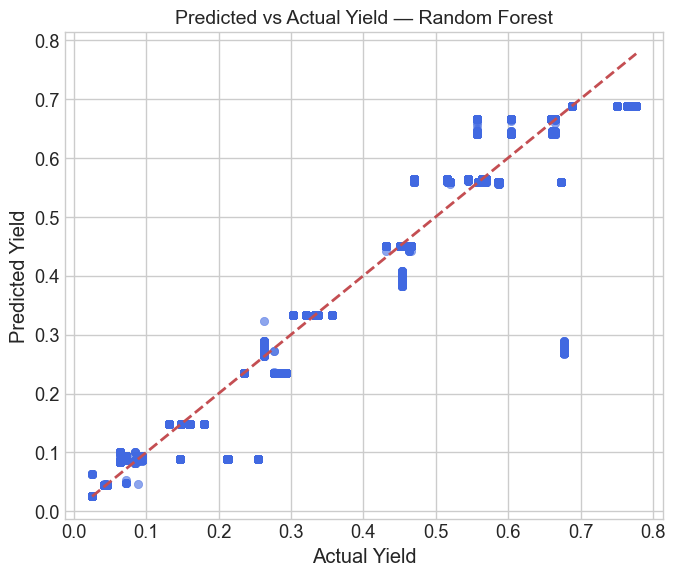

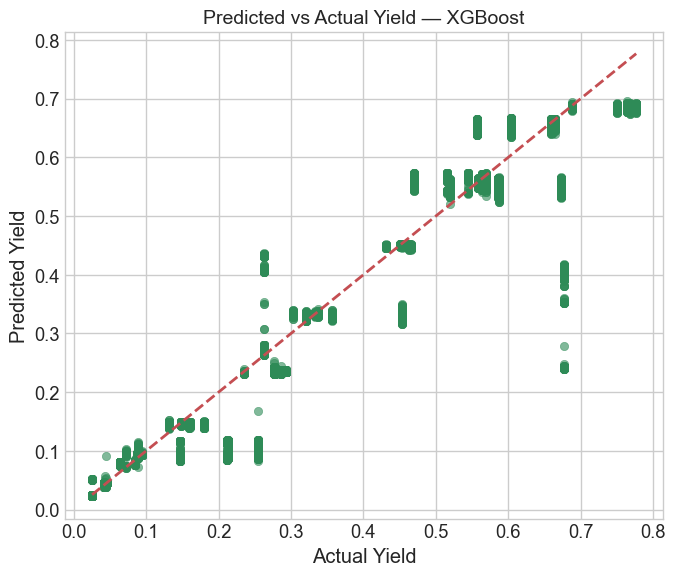

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')

# Random Forest
plt.figure(figsize=(7,6))
sns.scatterplot(x=y_test, y=y_pred_rf, color="royalblue", alpha=0.6, edgecolor=None)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title("Predicted vs Actual Yield — Random Forest", fontsize=14)
plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.tight_layout()
plt.show()

# XGBoost
plt.figure(figsize=(7,6))
sns.scatterplot(x=y_test, y=y_pred_xgb, color="seagreen", alpha=0.6, edgecolor=None)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title("Predicted vs Actual Yield — XGBoost", fontsize=14)
plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.tight_layout()
plt.show()


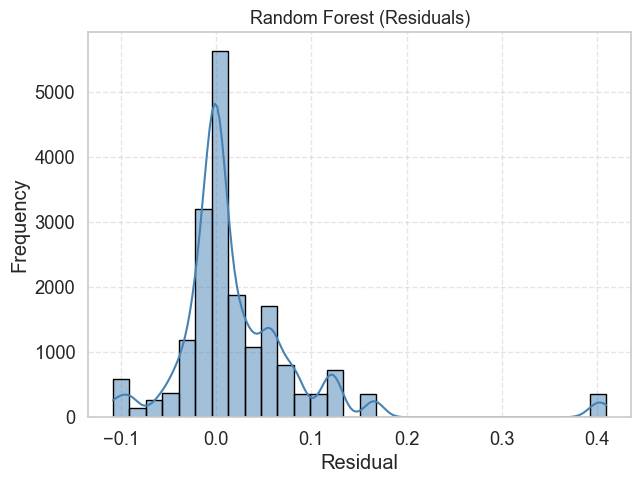

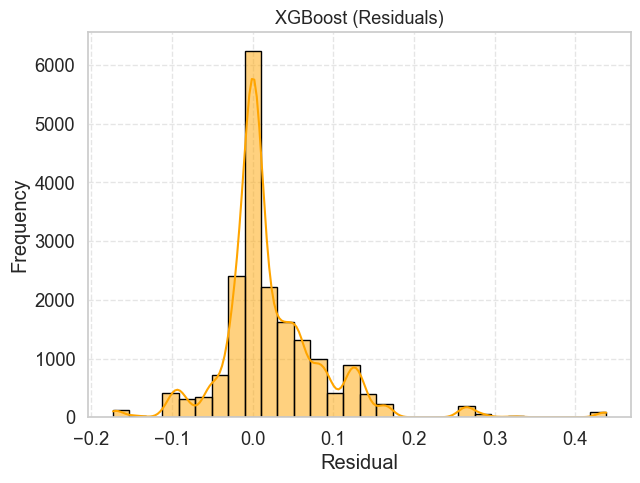

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

residuals_rf = y_test - y_pred_rf
residuals_xgb = y_test - y_pred_xgb

# === Random Forest Residuals Histogram ===
plt.figure(figsize=(7, 5))
sns.histplot(residuals_rf, bins=30, kde=True, color='steelblue', edgecolor='black')
plt.title("Random Forest (Residuals)", fontsize=13)
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# === XGBoost Residuals Histogram ===
plt.figure(figsize=(7, 5))
sns.histplot(residuals_xgb, bins=30, kde=True, color='orange', edgecolor='black')
plt.title("XGBoost (Residuals)", fontsize=13)
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
